In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Reading the csv file and cleaning the data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/rezw4n/LST_RNN_Model/master/Median_LST.csv')
df.dropna(inplace=True)

In [ ]:
df.head()

,Time,Median_LST
0,18-Feb-00,24.281
1,26-Feb-00,25.850
2,5-Mar-00,26.651
3,13-Mar-00,27.810
4,21-Mar-00,30.179


In [ ]:
df.index = df['Time']
df.drop('Time', axis=1, inplace=True)

# Normalize the data

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['LST'] = scaler.fit_transform(df['Median_LST'].values.reshape(-1, 1))

# Split data into training and testing sets

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [ ]:
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 7
trainX, trainY = create_dataset(train['LST'].values, look_back)
testX, testY = create_dataset(test['LST'].values, look_back)

# Reshape the data

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Building the LSTM model

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 50)                11600     
                                                                 
 dense_25 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11651 (45.51 KB)
Trainable params: 11651 (45.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train the model

In [ ]:
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
826/826 [==============================] - 3s 2ms/step - loss: 0.0268
Epoch 2/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 3/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0127
Epoch 4/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 5/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 6/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0120
Epoch 7/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 8/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0118
Epoch 9/100
826/826 [==============================] - 2s 2ms/step - loss: 0.0119
Epoch 10/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0117
Epoch 11/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0118
Epoch 12/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 13/100


# Make predictions

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

7/7 [==============================] - 0s 2ms/step


# Invert predictions

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculating the RMSE

In [ ]:
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 1.38
Test RMSE: 1.44


# Plotting predictions

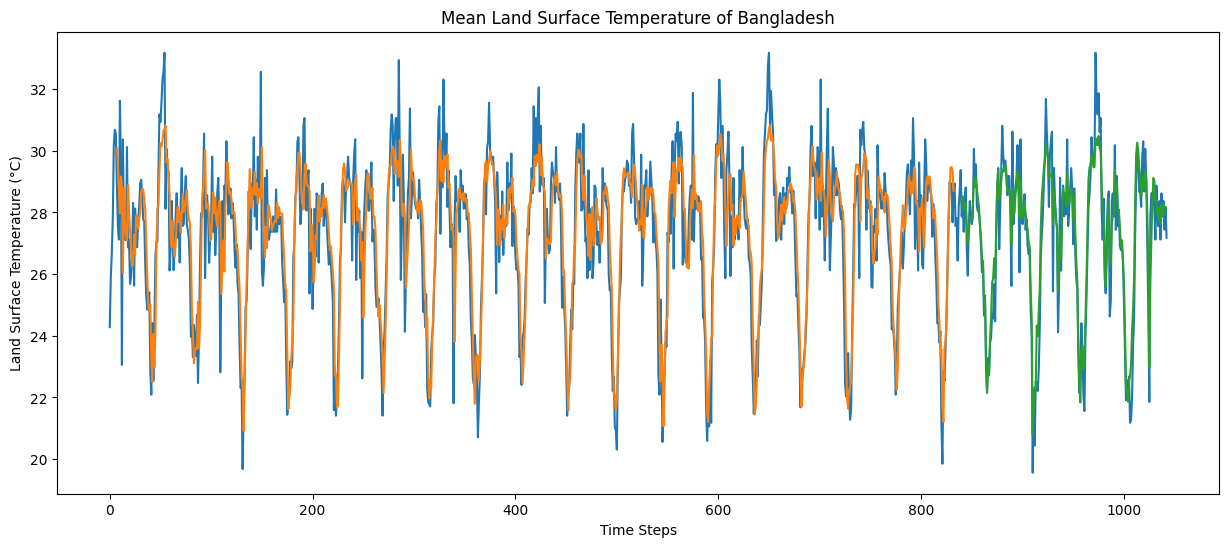

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['LST'].values.reshape(-1, 1)))
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict)
plt.plot(np.arange(len(trainPredict) + (2 * look_back), len(df) - 2), testPredict)

plt.title('Midian Land Surface Temperature of Bangladesh')
plt.xlabel('Time Steps')
plt.ylabel('Land Surface Temperature (°C)')
plt.show()

R^2 for train data: 0.69
R^2 for test data: 0.69


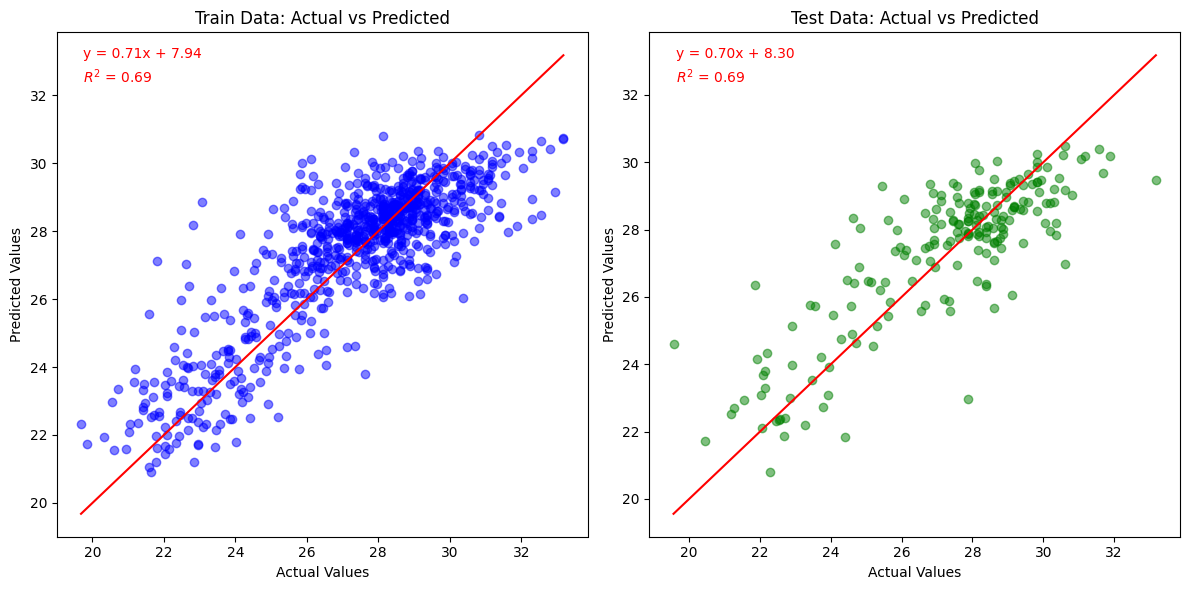

In [ ]:
from sklearn.metrics import r2_score


r2_train = r2_score(trainY[0], trainPredict[:, 0])
print(f"R^2 for train data: {r2_train:.2f}")

r2_test = r2_score(testY[0], testPredict[:, 0])
print(f"R^2 for test data: {r2_test:.2f}")

import numpy as np

# Calculate regression line parameters for training data
slope_train, intercept_train = np.polyfit(trainY[0], trainPredict[:, 0], 1)
regression_line_train = f'y = {slope_train:.2f}x + {intercept_train:.2f}'

# Calculate regression line parameters for testing data
slope_test, intercept_test = np.polyfit(testY[0], testPredict[:, 0], 1)
regression_line_test = f'y = {slope_test:.2f}x + {intercept_test:.2f}'

# Scatter plot for training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(trainY[0], trainPredict[:, 0], color='blue', alpha=0.5)
plt.plot([min(trainY[0]), max(trainY[0])], [min(trainY[0]), max(trainY[0])], 'r')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Train Data: Actual vs Predicted')
plt.annotate(regression_line_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')
plt.annotate(f'$R^2$ = {r2_train:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10, color='red')

# Scatter plot for testing data
plt.subplot(1, 2, 2)
plt.scatter(testY[0], testPredict[:, 0], color='green', alpha=0.5)
plt.plot([min(testY[0]), max(testY[0])], [min(testY[0]), max(testY[0])], 'r')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data: Actual vs Predicted')
plt.annotate(regression_line_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')
plt.annotate(f'$R^2$ = {r2_test:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10, color='red')

plt.tight_layout()
plt.show()

In [ ]:
# last_data = testX[-1].reshape(1, 1, look_back)

# n_future = 60
# future_predictions = []

# for i in range(n_future):
#     next_pred = model.predict(last_data)
#     future_predictions.append(next_pred[0][0])

#     new_data = np.append(last_data[0][0][1:], next_pred)
#     last_data = new_data.reshape(1, 1, look_back)


# future_predictions_original_scale = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# print(future_predictions_original_scale)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 50)                11600     
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 11651 (45.51 KB)
Trainable params: 11651 (45.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
826/826 [==============================] - 3s 2ms/step - loss: 0.0186
Epoch 2/100
826/826 [==============================] - 2s 3ms/step - loss: 0.0095
Epoch 3/100
826/826 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 4/100
826/826 [==============================] - 2s 2ms/step - loss: 0.0093
Epoch 5/100
826/826 [==============================] - 2s 2ms/step - loss: 0.0091
Epo

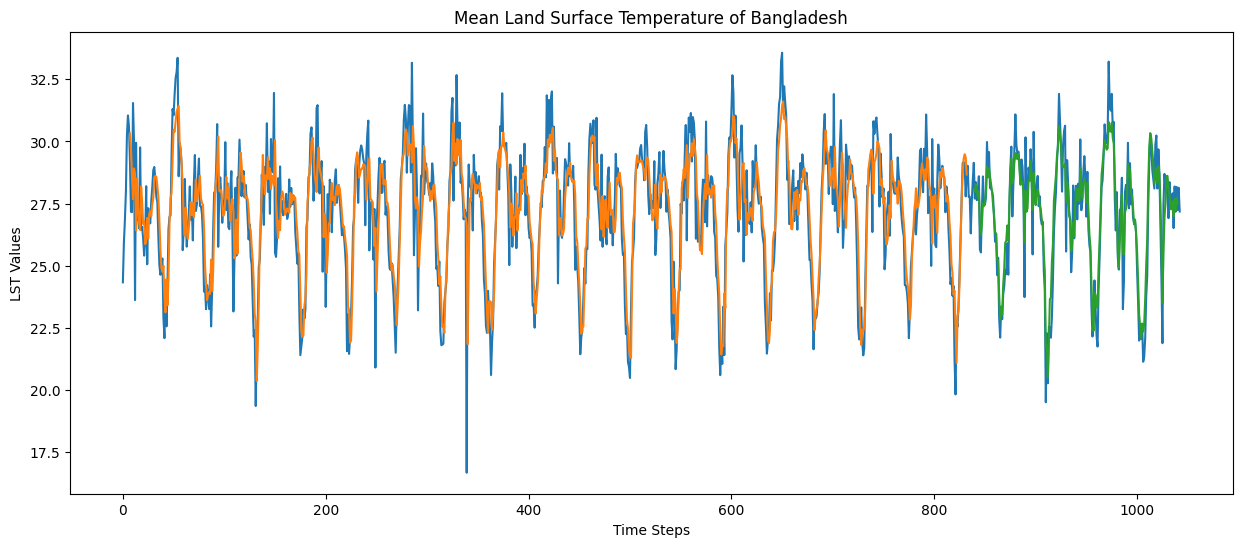

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/rezw4n/LST_RNN_Model/master/LST_Time_Series.csv')
df.dropna(inplace=True)

df.head()

df.index = df['Time']
df.drop('Time', axis=1, inplace=True)


scaler = MinMaxScaler(feature_range=(0, 1))
df['LST'] = scaler.fit_transform(df['LST'].values.reshape(-1, 1))

train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 7
trainX, trainY = create_dataset(train['LST'].values, look_back)
testX, testY = create_dataset(test['LST'].values, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)


trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))


plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['LST'].values.reshape(-1, 1)))
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict)
plt.plot(np.arange(len(trainPredict) + (2 * look_back), len(df) - 2), testPredict)

plt.title('Mean Land Surface Temperature of Bangladesh')
plt.xlabel('Time Steps')
plt.ylabel('LST Values')
plt.show()

# Support Vector Machine

Train RMSE: 1.36
Test RMSE: 1.45


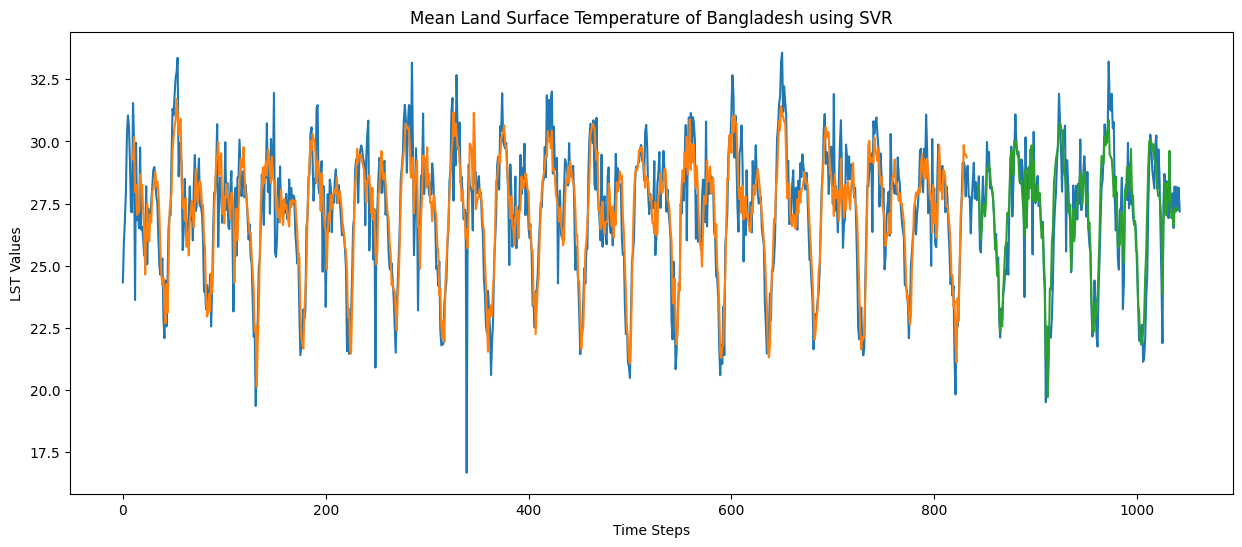

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# Reading the csv file and cleaning the data
df = pd.read_csv('https://raw.githubusercontent.com/rezw4n/LST_RNN_Model/master/LST_Time_Series.csv')
df.dropna(inplace=True)
df.index = df['Time']
df.drop('Time', axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['LST'] = scaler.fit_transform(df['LST'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10
trainX, trainY = create_dataset(train['LST'].values, look_back)
testX, testY = create_dataset(test['LST'].values, look_back)

# Flatten the input data
trainX = trainX.reshape(trainX.shape[0], look_back)
testX = testX.reshape(testX.shape[0], look_back)

# Building the SVR model
model = SVR(kernel='rbf', C=1e3, gamma=0.1)
model.fit(trainX, trainY)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculating the RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.2f' % (testScore))

# Plotting predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['LST'].values.reshape(-1, 1)))
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict)
plt.plot(np.arange(len(trainPredict) + (2 * look_back), len(df) - 2), testPredict)
plt.title('Mean Land Surface Temperature of Bangladesh using SVR')
plt.xlabel('Time Steps')
plt.ylabel('LST Values')
plt.show()

# Random Forest

Train RMSE: 0.54
Test RMSE: 1.41


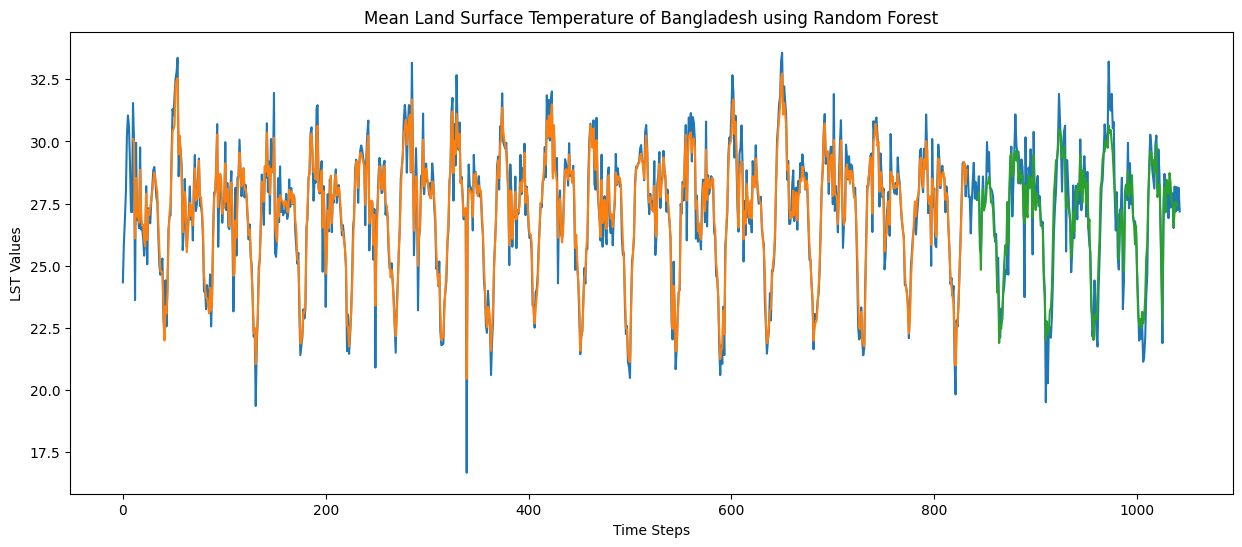

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Reading the csv file and cleaning the data
df = pd.read_csv('https://raw.githubusercontent.com/rezw4n/LST_RNN_Model/master/LST_Time_Series.csv')
df.dropna(inplace=True)
df.index = df['Time']
df.drop('Time', axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['LST'] = scaler.fit_transform(df['LST'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10
trainX, trainY = create_dataset(train['LST'].values, look_back)
testX, testY = create_dataset(test['LST'].values, look_back)

# Flatten the input data
trainX = trainX.reshape(trainX.shape[0], look_back)
testX = testX.reshape(testX.shape[0], look_back)

# Building the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(trainX, trainY)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculating the RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.2f' % (testScore))

# Plotting predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['LST'].values.reshape(-1, 1)))
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict)
plt.plot(np.arange(len(trainPredict) + (2 * look_back), len(df) - 2), testPredict)
plt.title('Mean Land Surface Temperature of Bangladesh using Random Forest')
plt.xlabel('Time Steps')
plt.ylabel('LST Values')
plt.show()

# Ensemble between Random Forest and LSTM

Epoch 1/100
823/823 [==============================] - 4s 2ms/step - loss: 0.0208
Epoch 2/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0095
Epoch 3/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0092
Epoch 4/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 5/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0091
Epoch 6/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 7/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0089
Epoch 8/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 9/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0088
Epoch 10/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 11/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0088
Epoch 12/100
823/823 [==============================] - 1s 2ms/step - loss: 0.0086
Epoch 13/100


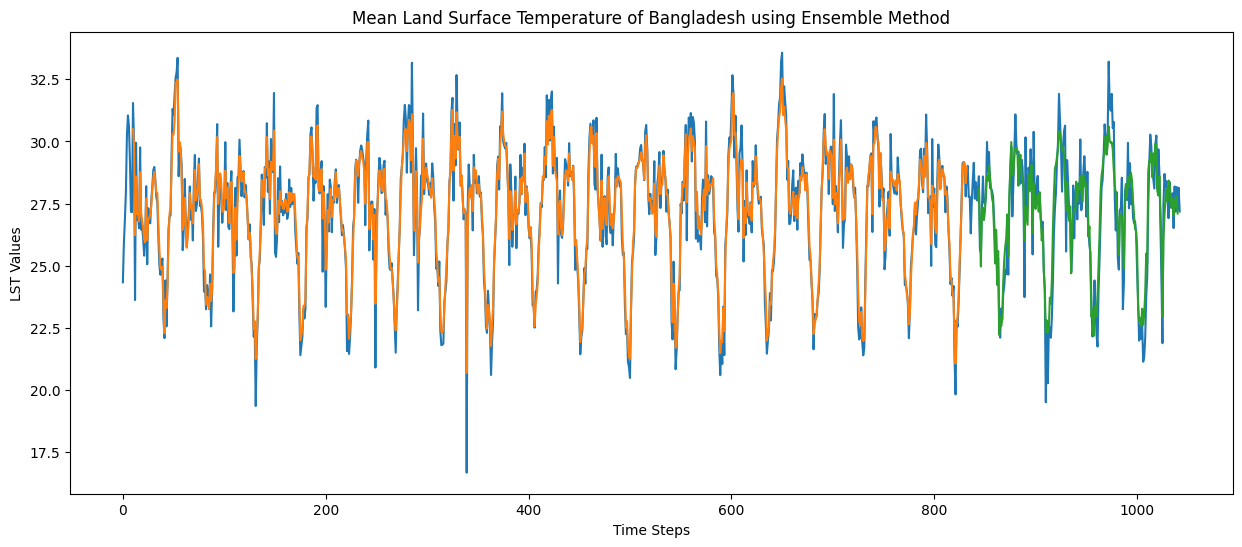

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Reading the csv file and cleaning the data
df = pd.read_csv('https://raw.githubusercontent.com/rezw4n/LST_RNN_Model/master/LST_Time_Series.csv')
df.dropna(inplace=True)
df.index = df['Time']
df.drop('Time', axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['LST'] = scaler.fit_transform(df['LST'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10
trainX, trainY = create_dataset(train['LST'].values, look_back)
testX, testY = create_dataset(test['LST'].values, look_back)

# LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
trainX_reshaped = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_reshaped = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model.fit(trainX_reshaped, trainY, epochs=100, batch_size=1, verbose=1)

# Predictions from LSTM
trainPredict_lstm = model.predict(trainX_reshaped)
testPredict_lstm = model.predict(testX_reshaped)

# Flatten the input data for Random Forest
trainX_flat = trainX.reshape(trainX.shape[0], look_back)
testX_flat = testX.reshape(testX.shape[0], look_back)

# Define base models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
]

# Create ensemble model
ensemble = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Use LSTM predictions as additional features
trainX_combined = np.hstack((trainX_flat, trainPredict_lstm))
testX_combined = np.hstack((testX_flat, testPredict_lstm))

# Train ensemble model
ensemble.fit(trainX_combined, trainY)

# Make predictions
trainPredict = ensemble.predict(trainX_combined)
testPredict = ensemble.predict(testX_combined)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Calculating the RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.2f' % (testScore))

# Plotting predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['LST'].values.reshape(-1, 1)))
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict)
plt.plot(np.arange(len(trainPredict) + (2 * look_back), len(df) - 2), testPredict)
plt.title('Mean Land Surface Temperature of Bangladesh using Ensemble Method')
plt.xlabel('Time Steps')
plt.ylabel('LST Values')
plt.show()

Epoch 1/200
26/26 [==============================] - 1s 5ms/step - loss: 0.1734
Epoch 2/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 6/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 7/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0096
Epoch 8/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 9/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 10/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0095
Epoch 11/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 12/200
26/26 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 13/200
26/26 [=================

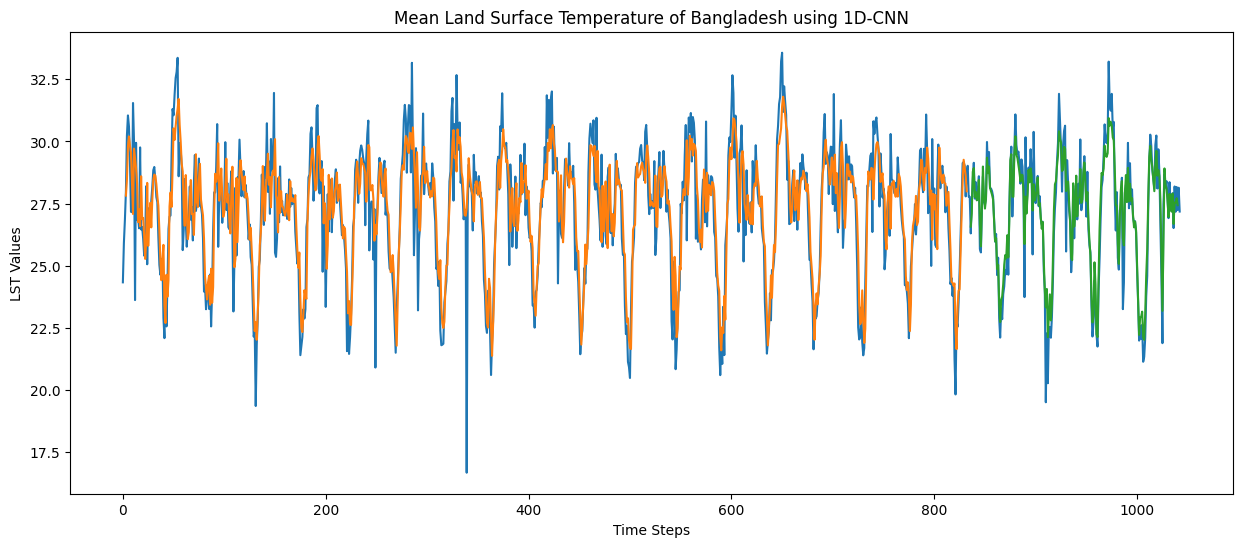

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
import matplotlib.pyplot as plt

# Reading the csv file and cleaning the data
df = pd.read_csv('https://raw.githubusercontent.com/rezw4n/LST_RNN_Model/master/LST_Time_Series.csv')
df.dropna(inplace=True)
df.index = df['Time']
df.drop('Time', axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['LST'] = scaler.fit_transform(df['LST'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 3
trainX, trainY = create_dataset(train['LST'].values, look_back)
testX, testY = create_dataset(test['LST'].values, look_back)

# Reshape the data for 1D-CNN
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Building the 1D-CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(trainX, trainY, epochs=200, verbose=1)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculating the RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))

# Plotting predictions
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['LST'].values.reshape(-1, 1)))
plt.plot(np.arange(look_back, len(trainPredict) + look_back), trainPredict)
plt.plot(np.arange(len(trainPredict) + (2 * look_back), len(df) - 2), testPredict)
plt.title('Mean Land Surface Temperature of Bangladesh using 1D-CNN')
plt.xlabel('Time Steps')
plt.ylabel('LST Values')
plt.show()